In [1]:
ASSET = "ETHUSDT"
TARGET = "MA_7"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,3765.54,154143.8968,Extreme Fear,0.024004,0.026033,42.401026,32.253914,-194.39,102.99,100.23,-2.76,0.499123,0.000711,-26.058066,3810.681429,3913.564286
2022-01-02,3828.27,154791.4263,Fear,0.016522,0.026513,44.955812,32.149459,-95.87,140.14,91.90,-48.24,0.524547,0.000770,-28.146396,3777.068571,3906.716429
2022-01-03,3765.89,236245.8586,Fear,-0.016429,0.026705,42.917239,32.213325,-178.84,173.09,24.98,-148.11,0.485007,0.000666,-30.916813,3738.305714,3893.942143
2022-01-04,3785.11,288258.5549,Extreme Fear,0.005091,0.026165,43.763398,31.865518,-229.04,187.62,134.84,-52.78,0.511717,0.000616,-30.063407,3737.214286,3877.582143
2022-01-05,3540.63,397942.0363,Extreme Fear,-0.066770,0.031075,36.376773,32.705154,-438.88,433.00,62.90,-370.10,0.461943,0.000657,-36.330352,3724.420000,3846.233571


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:46,677] A new study created in memory with name: no-name-a0752a16-e36b-4ce7-a793-0a95b69988ea


Epoch 1/47


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.1465 - val_loss: 0.0057
Epoch 2/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0119 - val_loss: 0.0040
Epoch 3/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0074 - val_loss: 0.0029
Epoch 4/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0072 - val_loss: 0.0040
Epoch 5/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 6/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 7/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 8/47
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0068 - val_loss: 0.0045
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2025-05-09 19:33:54,966] Trial 0 finished with value: 24089.508538176924 and parameters: {'units_l0': 118, 'dropout_l0': 0.14329164725329308, 'learning_rate': 0.003911072532823822, 'batch_size': 64, 'max_epochs': 47, 'sequence_length': 59}. Best is trial 0 with value: 24089.508538176924.


Epoch 1/48


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.3122 - val_loss: 0.0123
Epoch 2/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0148 - val_loss: 0.0056
Epoch 3/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 4/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 5/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0071 - val_loss: 0.0134
Epoch 6/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0063 - val_loss: 0.0118
Epoch 7/48
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0080 - val_loss: 0.0071
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-05-09 19:34:02,328] Trial 1 finished with value: 45629.608700340825 and parameters: {'units_l0': 148, 'dropout_l0': 0.208680434503413, 'learning_rate': 0.005733339288097087, 'batch_size': 32, 'max_epochs': 48, 'sequence_length': 28}. Best is trial 0 with value: 24089.508538176924.


Epoch 1/31


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1992 - val_loss: 0.3384
Epoch 2/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1083 - val_loss: 0.1942
Epoch 3/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0805 - val_loss: 0.1242
Epoch 4/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0697 - val_loss: 0.0941
Epoch 5/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0635 - val_loss: 0.0786
Epoch 6/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0524 - val_loss: 0.0613
Epoch 7/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0450 - val_loss: 0.0488
Epoch 8/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0358 - val_loss: 0.0395
Epoch 9/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0375 - val_loss: 0.0328
Epoch 10/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0294 - val_loss: 0.0247
Epoch 11/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0264 - val_loss: 0.0192
Epoch 12/31
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0254 - val_l

[I 2025-05-09 19:34:20,432] Trial 2 finished with value: 28113.29865965666 and parameters: {'units_l0': 111, 'dropout_l0': 0.2216935958284879, 'learning_rate': 2.5711563350356624e-05, 'batch_size': 32, 'max_epochs': 31, 'sequence_length': 19}. Best is trial 0 with value: 24089.508538176924.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0811 - val_loss: 0.0263
Epoch 2/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0260 - val_loss: 0.0088
Epoch 3/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0221 - val_loss: 0.0152
Epoch 4/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0201 - val_loss: 0.0182
Epoch 5/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0146 - val_loss: 0.0097
Epoch 6/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0166 - val_loss: 0.0125
Epoch 7/96
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0136 - val_loss: 0.0189
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-05-09 19:34:30,422] Trial 3 finished with value: 71755.50495533919 and parameters: {'units_l0': 68, 'dropout_l0': 0.3615403984167171, 'learning_rate': 0.000646993151756726, 'batch_size': 64, 'max_epochs': 96, 'sequence_length': 38}. Best is trial 0 with value: 24089.508538176924.


Epoch 1/52


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.3300 - val_loss: 0.4547
Epoch 2/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1873 - val_loss: 0.2268
Epoch 3/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1009 - val_loss: 0.1097
Epoch 4/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0727 - val_loss: 0.0608
Epoch 5/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0559 - val_loss: 0.0409
Epoch 6/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0544 - val_loss: 0.0284
Epoch 7/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0437 - val_loss: 0.0206
Epoch 8/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0388 - val_loss: 0.0137
Epoch 9/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0355 - val_loss: 0.0106
Epoch 10/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0278 - val_loss: 0.0081
Epoch 11/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0307 - val_loss: 0.0064
Epoch 12/52
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0277 - val_l

[I 2025-05-09 19:34:52,564] Trial 4 finished with value: 39493.93364977444 and parameters: {'units_l0': 51, 'dropout_l0': 0.39174708777702916, 'learning_rate': 6.596149323342912e-05, 'batch_size': 32, 'max_epochs': 52, 'sequence_length': 56}. Best is trial 0 with value: 24089.508538176924.


Epoch 1/20


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0870 - val_loss: 0.0207
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0224 - val_loss: 0.0393
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0480
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0671
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - val_loss: 0.0815
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - val_loss: 0.0738
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[I 2025-05-09 19:34:59,217] Trial 5 finished with value: 169470.6174308268 and parameters: {'units_l0': 80, 'dropout_l0': 0.4411902332776321, 'learning_rate': 0.007711557331467877, 'batch_size': 16, 'max_epochs': 20, 'sequence_length': 10}. Best is trial 0 with value: 24089.508538176924.


Epoch 1/55


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1112 - val_loss: 0.0638
Epoch 2/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0438 - val_loss: 0.0313
Epoch 3/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0288 - val_loss: 0.0240
Epoch 4/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0274 - val_loss: 0.0183
Epoch 5/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0231 - val_loss: 0.0207
Epoch 6/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0247 - val_loss: 0.0166
Epoch 7/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0227 - val_loss: 0.0147
Epoch 8/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0231 - val_loss: 0.0172
Epoch 9/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 10/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0200 - val_loss: 0.0208
Epoch 11/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0220 - val_loss: 0.0198
Epoch 12/55
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0183 - val_l

[I 2025-05-09 19:35:18,478] Trial 6 finished with value: 120184.78789268793 and parameters: {'units_l0': 189, 'dropout_l0': 0.44608003107352173, 'learning_rate': 3.941231860966136e-05, 'batch_size': 32, 'max_epochs': 55, 'sequence_length': 51}. Best is trial 0 with value: 24089.508538176924.


Epoch 1/25


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0343 - val_loss: 0.0464
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0246 - val_loss: 0.0261
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0170 - val_loss: 0.0195
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0086 - val_loss: 0.0067
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0051 - val_l

[I 2025-05-09 19:35:53,866] Trial 7 finished with value: 14073.240407947505 and parameters: {'units_l0': 163, 'dropout_l0': 0.05315323560047508, 'learning_rate': 1.4812933808200485e-05, 'batch_size': 32, 'max_epochs': 25, 'sequence_length': 54}. Best is trial 7 with value: 14073.240407947505.


Epoch 1/39


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.6375 - val_loss: 0.0218
Epoch 2/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0166 - val_loss: 0.0075
Epoch 3/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0140 - val_loss: 0.0104
Epoch 4/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 5/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0124 - val_loss: 0.0092
Epoch 6/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0121 - val_loss: 0.0063
Epoch 7/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0138 - val_loss: 0.0101
Epoch 8/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0085 - val_loss: 0.0316
Epoch 9/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0077 - val_loss: 0.0192
Epoch 10/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0063 - val_loss: 0.0306
Epoch 11/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0051 - val_loss: 0.0263
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2025-05-09 19:36:18,466] Trial 8 finished with value: 51621.88326005756 and parameters: {'units_l0': 186, 'dropout_l0': 0.3056662790831616, 'learning_rate': 0.006698154577301903, 'batch_size': 32, 'max_epochs': 39, 'sequence_length': 56}. Best is trial 7 with value: 14073.240407947505.


Epoch 1/87


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.1842 - val_loss: 0.0154
Epoch 2/87
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0166 - val_loss: 0.0312
Epoch 3/87
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0160 - val_loss: 0.0443
Epoch 4/87
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0133 - val_loss: 0.0867
Epoch 5/87
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0103 - val_loss: 0.0615
Epoch 6/87
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0070 - val_loss: 0.0610
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[I 2025-05-09 19:36:38,715] Trial 9 finished with value: 126129.43659645392 and parameters: {'units_l0': 169, 'dropout_l0': 0.40760407363895224, 'learning_rate': 0.004488358271073074, 'batch_size': 16, 'max_epochs': 87, 'sequence_length': 60}. Best is trial 7 with value: 14073.240407947505.


Epoch 1/73


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0563 - val_loss: 0.1233
Epoch 2/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0414 - val_loss: 0.0929
Epoch 3/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0311 - val_loss: 0.0748
Epoch 4/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0231 - val_loss: 0.0539
Epoch 5/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0169 - val_loss: 0.0395
Epoch 6/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0108 - val_loss: 0.0281
Epoch 7/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0067 - val_loss: 0.0207
Epoch 8/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045 - val_loss: 0.0151
Epoch 9/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032 - val_loss: 0.0143
Epoch 10/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0024 - val_loss: 0.0120
Epoch 11/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 0.0112
Epoch 12/73
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_l

[I 2025-05-09 19:37:22,175] Trial 10 finished with value: 73688.01350777918 and parameters: {'units_l0': 145, 'dropout_l0': 0.006099386476915283, 'learning_rate': 1.1511343794621657e-05, 'batch_size': 16, 'max_epochs': 73, 'sequence_length': 43}. Best is trial 7 with value: 14073.240407947505.


Epoch 1/11


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.2347 - val_loss: 0.0114
Epoch 2/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0290 - val_loss: 0.0387
Epoch 3/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0119 - val_loss: 0.0035
Epoch 4/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0069 - val_loss: 0.0035
Epoch 5/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 6/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 7/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 8/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 9/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 10/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 11/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0049 - val_loss: 0.0016
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


[I 2025-05-09 19:37:38,328] Trial 11 finished with value: 13170.55511847087 and parameters: {'units_l0': 115, 'dropout_l0': 0.07463698106929312, 'learning_rate': 0.0004775171506905203, 'batch_size': 64, 'max_epochs': 11, 'sequence_length': 46}. Best is trial 11 with value: 13170.55511847087.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0825 - val_loss: 0.0490
Epoch 2/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0289 - val_loss: 0.0131
Epoch 3/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 4/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 5/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 6/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 7/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 8/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 9/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 11/11
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - val_loss: 0.0043
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-05-09 19:37:52,990] Trial 12 finished with value: 26056.56709659224 and parameters: {'units_l0': 93, 'dropout_l0': 0.015711777916740055, 'learning_rate': 0.0002636316434718316, 'batch_size': 64, 'max_epochs': 11, 'sequence_length': 45}. Best is trial 11 with value: 13170.55511847087.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0953 - val_loss: 0.0431
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0191 - val_loss: 0.0037
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0094 - val_loss: 0.0029
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0062 - val_loss: 0.0060
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


[I 2025-05-09 19:38:08,418] Trial 13 finished with value: 23330.75318844879 and parameters: {'units_l0': 143, 'dropout_l0': 0.11092990052387168, 'learning_rate': 0.0003723029548433178, 'batch_size': 64, 'max_epochs': 10, 'sequence_length': 48}. Best is trial 11 with value: 13170.55511847087.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0816 - val_loss: 0.0225
Epoch 2/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0284 - val_loss: 0.0318
Epoch 3/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0127 - val_loss: 0.0043
Epoch 4/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0079 - val_loss: 0.0048
Epoch 5/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0081 - val_loss: 0.0038
Epoch 6/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 7/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 8/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 9/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 10/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 11/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 12/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0

[I 2025-05-09 19:38:29,707] Trial 14 finished with value: 23826.31450433438 and parameters: {'units_l0': 168, 'dropout_l0': 0.09143049636002222, 'learning_rate': 0.0001334996971915852, 'batch_size': 64, 'max_epochs': 27, 'sequence_length': 34}. Best is trial 11 with value: 13170.55511847087.


Epoch 1/22


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0855 - val_loss: 0.0056
Epoch 2/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0069 - val_loss: 0.0042
Epoch 3/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 4/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 5/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 0.0059
Epoch 7/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 9/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - val_loss: 0.0078
Epoch 10/22
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033 - val_loss: 0.0050
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-05-09 19:38:42,599] Trial 15 finished with value: 10662.462030661467 and parameters: {'units_l0': 104, 'dropout_l0': 0.05705807144071627, 'learning_rate': 0.0013147658708378442, 'batch_size': 32, 'max_epochs': 22, 'sequence_length': 38}. Best is trial 15 with value: 10662.462030661467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0561 - val_loss: 0.0055
Epoch 2/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0119 - val_loss: 0.0070
Epoch 3/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0094 - val_loss: 0.0079
Epoch 4/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0078 - val_loss: 0.0097
Epoch 5/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 6/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0071 - val_loss: 0.0117
Epoch 7/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 8/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 9/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065 - val_loss: 0.0125
Epoch 10/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0044 - val_loss: 0.0177
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2025-05-09 19:38:53,289] Trial 16 finished with value: 41581.367938709824 and parameters: {'units_l0': 102, 'dropout_l0': 0.16097866258209576, 'learning_rate': 0.0013317060938908337, 'batch_size': 64, 'max_epochs': 17, 'sequence_length': 32}. Best is trial 15 with value: 10662.462030661467.


Epoch 1/68


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.1239 - val_loss: 0.0113
Epoch 2/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 3/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 4/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0106 - val_loss: 0.0172
Epoch 5/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0101 - val_loss: 0.0213
Epoch 6/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0072 - val_loss: 0.0176
Epoch 7/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0084 - val_loss: 0.0414
Epoch 8/68
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0047 - val_loss: 0.0266
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[I 2025-05-09 19:39:04,313] Trial 17 finished with value: 77078.25934563697 and parameters: {'units_l0': 124, 'dropout_l0': 0.28590732769276184, 'learning_rate': 0.0015385504204778304, 'batch_size': 32, 'max_epochs': 68, 'sequence_length': 42}. Best is trial 15 with value: 10662.462030661467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.1334 - val_loss: 0.0097
Epoch 2/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0139 - val_loss: 0.0231
Epoch 3/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 4/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0057 - val_loss: 0.0035
Epoch 5/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 6/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 7/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 9/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 10/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 11/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 12/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0

[I 2025-05-09 19:39:15,813] Trial 18 finished with value: 20149.721706408527 and parameters: {'units_l0': 84, 'dropout_l0': 0.07043454748253675, 'learning_rate': 0.0015860745156744333, 'batch_size': 64, 'max_epochs': 36, 'sequence_length': 26}. Best is trial 15 with value: 10662.462030661467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0572 - val_loss: 0.0039
Epoch 2/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 3/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 4/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 5/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0058 - val_loss: 0.0070
Epoch 6/19
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0065 - val_loss: 0.0223
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-05-09 19:39:25,822] Trial 19 finished with value: 31656.225093579887 and parameters: {'units_l0': 133, 'dropout_l0': 0.1545424279840172, 'learning_rate': 0.0006660173022341974, 'batch_size': 16, 'max_epochs': 19, 'sequence_length': 39}. Best is trial 15 with value: 10662.462030661467.


Epoch 1/32


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1206 - val_loss: 0.0441
Epoch 2/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0403 - val_loss: 0.0247
Epoch 3/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0225 - val_loss: 0.0112
Epoch 4/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0168 - val_loss: 0.0052
Epoch 5/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0160 - val_loss: 0.0050
Epoch 6/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0130 - val_loss: 0.0048
Epoch 7/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0125 - val_loss: 0.0054
Epoch 8/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0120 - val_loss: 0.0046
Epoch 9/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0108 - val_loss: 0.0046
Epoch 10/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0112 - val_loss: 0.0045
Epoch 11/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 12/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0098 - val_l

[I 2025-05-09 19:39:39,204] Trial 20 finished with value: 36043.09275717526 and parameters: {'units_l0': 107, 'dropout_l0': 0.19779450699254164, 'learning_rate': 0.00015385758645644802, 'batch_size': 64, 'max_epochs': 32, 'sequence_length': 23}. Best is trial 15 with value: 10662.462030661467.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0360 - val_loss: 0.0091
Epoch 2/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 3/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 4/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 5/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 6/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 7/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 8/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 9/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0018 - val_loss: 0.0052
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-05-09 19:39:56,368] Trial 21 finished with value: 9715.161814802823 and parameters: {'units_l0': 165, 'dropout_l0': 0.051283644178512756, 'learning_rate': 0.0006885809430232475, 'batch_size': 32, 'max_epochs': 24, 'sequence_length': 51}. Best is trial 21 with value: 9715.161814802823.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0686 - val_loss: 0.0073
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018 - val_loss: 9.5742e-04
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 9/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 11/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0018 - val_loss: 7.1665e-04
Epoch 12/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - l

[I 2025-05-09 19:40:23,254] Trial 22 finished with value: 5656.023805608233 and parameters: {'units_l0': 131, 'dropout_l0': 0.028709404309261277, 'learning_rate': 0.000807178392116715, 'batch_size': 32, 'max_epochs': 40, 'sequence_length': 49}. Best is trial 22 with value: 5656.023805608233.


Epoch 1/45


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0458 - val_loss: 0.0069
Epoch 2/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 3/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 4/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 7/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 9/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 10/45
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 - val_loss: 0.0028
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


[I 2025-05-09 19:40:39,991] Trial 23 finished with value: 8743.497114948474 and parameters: {'units_l0': 133, 'dropout_l0': 0.035156179020504504, 'learning_rate': 0.0020933477325439055, 'batch_size': 32, 'max_epochs': 45, 'sequence_length': 52}. Best is trial 22 with value: 5656.023805608233.


Epoch 1/59


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0720 - val_loss: 0.0038
Epoch 2/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 3/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.3913e-04 - val_loss: 0.0012
Epoch 4/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.3979e-04 - val_loss: 0.0012
Epoch 5/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.9524e-04 - val_loss: 0.0027
Epoch 6/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.8741e-04 - val_loss: 0.0018
Epoch 7/59
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.6733e-04 - val_loss: 0.0018
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-05-09 19:40:52,710] Trial 24 finished with value: 9348.802761778401 and parameters: {'units_l0': 133, 'dropout_l0': 0.0011186964752564338, 'learning_rate': 0.00301574798855679, 'batch_size': 32, 'max_epochs': 59, 'sequence_length': 51}. Best is trial 22 with value: 5656.023805608233.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0529 - val_loss: 0.0088
Epoch 2/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020 - val_loss: 9.6470e-04
Epoch 3/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.3194e-04 - val_loss: 5.9522e-04
Epoch 4/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.0402e-04 - val_loss: 8.4018e-04
Epoch 5/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.7019e-04 - val_loss: 6.5275e-04
Epoch 6/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.2429e-04 - val_loss: 7.9398e-04
Epoch 7/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.2134e-04 - val_loss: 9.2483e-04
Epoch 8/69
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 1.2267e-04 - val_loss: 9.8654e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-05-09 19:41:08,402] Trial 25 finished with value: 4866.187339948818 and parameters: {'units_l0': 135, 'dropout_l0': 0.00024630948315312873, 'learning_rate': 0.0028573446239732814, 'batch_size': 32, 'max_epochs': 69, 'sequence_length': 51}. Best is trial 25 with value: 4866.187339948818.


Epoch 1/66


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0665 - val_loss: 0.0142
Epoch 2/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 3/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0068 - val_loss: 0.0073
Epoch 4/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 5/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0060 - val_loss: 0.0135
Epoch 6/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0045 - val_loss: 0.0166
Epoch 7/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0033 - val_loss: 0.0205
Epoch 8/66
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028 - val_loss: 0.0075
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-05-09 19:41:24,500] Trial 26 finished with value: 59460.442276818874 and parameters: {'units_l0': 152, 'dropout_l0': 0.1263874728048653, 'learning_rate': 0.0025671156450714893, 'batch_size': 32, 'max_epochs': 66, 'sequence_length': 49}. Best is trial 25 with value: 4866.187339948818.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0683 - val_loss: 0.0362
Epoch 2/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0224 - val_loss: 0.0343
Epoch 3/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0188 - val_loss: 0.0437
Epoch 4/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0195 - val_loss: 0.0901
Epoch 5/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0138 - val_loss: 0.0929
Epoch 6/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0125 - val_loss: 0.1049
Epoch 7/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0128 - val_loss: 0.1379
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-05-09 19:41:38,900] Trial 27 finished with value: 280791.4270017826 and parameters: {'units_l0': 131, 'dropout_l0': 0.49381375110527037, 'learning_rate': 0.0023091501021134733, 'batch_size': 32, 'max_epochs': 78, 'sequence_length': 54}. Best is trial 25 with value: 4866.187339948818.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0488 - val_loss: 0.0037
Epoch 2/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 3/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 5/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 7/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 8/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 9/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 11/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12/42
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0

[I 2025-05-09 19:41:59,583] Trial 28 finished with value: 13799.283406432663 and parameters: {'units_l0': 158, 'dropout_l0': 0.03168681494916279, 'learning_rate': 0.0009222186756605508, 'batch_size': 32, 'max_epochs': 42, 'sequence_length': 42}. Best is trial 25 with value: 4866.187339948818.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.1029 - val_loss: 0.0072
Epoch 2/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 3/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 4/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 5/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0066 - val_loss: 0.0124
Epoch 6/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 7/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0042 - val_loss: 0.0113
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-05-09 19:42:13,428] Trial 29 finished with value: 21818.894197890222 and parameters: {'units_l0': 123, 'dropout_l0': 0.11507835301637895, 'learning_rate': 0.003744541002953134, 'batch_size': 32, 'max_epochs': 61, 'sequence_length': 59}. Best is trial 25 with value: 4866.187339948818.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0543 - val_loss: 0.0065
Epoch 2/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0137 - val_loss: 0.0079
Epoch 3/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0108 - val_loss: 0.0037
Epoch 4/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 5/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0075 - val_loss: 0.0043
Epoch 6/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 7/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 8/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0088 - val_loss: 0.0103
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


[I 2025-05-09 19:42:29,078] Trial 30 finished with value: 30151.863321800196 and parameters: {'units_l0': 138, 'dropout_l0': 0.17979370023392546, 'learning_rate': 0.0002008641075356748, 'batch_size': 32, 'max_epochs': 46, 'sequence_length': 55}. Best is trial 25 with value: 4866.187339948818.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.6207 - val_loss: 0.0058
Epoch 2/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 3/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.2081e-04 - val_loss: 0.0018
Epoch 4/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.0500e-04 - val_loss: 0.0020
Epoch 5/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.1899e-04 - val_loss: 0.0022
Epoch 6/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 6.7076e-04 - val_loss: 0.0015
Epoch 7/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.7928e-04 - val_loss: 6.3623e-04
Epoch 8/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.2497e-04 - val_loss: 6.4117e-04
Epoch 9/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.3186e-04 - val_loss: 9.0327e-04
Epoch 10/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.4344e-04 - val_loss: 4.3590e-04
Epoch 11/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.3080e-04 - val_loss: 0.0010
Epoch 12/61

[I 2025-05-09 19:42:54,164] Trial 31 finished with value: 3074.190274311261 and parameters: {'units_l0': 129, 'dropout_l0': 0.0035807956104772416, 'learning_rate': 0.009762332549922835, 'batch_size': 32, 'max_epochs': 61, 'sequence_length': 51}. Best is trial 31 with value: 3074.190274311261.


Epoch 1/50


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.5418 - val_loss: 0.0237
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - val_loss: 0.0037
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-05-09 19:43:09,454] Trial 32 finished with value: 11275.813609221317 and parameters: {'units_l0': 123, 'dropout_l0': 0.03288887133781705, 'learning_rate': 0.009927410340363823, 'batch_size': 32, 'max_epochs': 50, 'sequence_length': 47}. Best is trial 31 with value: 3074.190274311261.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0619 - val_loss: 0.0040
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0040 - val_loss: 0.0093
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0047 - val_loss: 0.0124
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


[I 2025-05-09 19:43:22,581] Trial 33 finished with value: 16757.2273117705 and parameters: {'units_l0': 152, 'dropout_l0': 0.09276818858370132, 'learning_rate': 0.002158322187051271, 'batch_size': 32, 'max_epochs': 80, 'sequence_length': 50}. Best is trial 31 with value: 3074.190274311261.


Epoch 1/44


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.4521 - val_loss: 0.0101
Epoch 2/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 3/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 4/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 5/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 8/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 9/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 10/44
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0025 - val_loss: 0.0110
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-05-09 19:43:43,766] Trial 34 finished with value: 12616.003732594418 and parameters: {'units_l0': 177, 'dropout_l0': 0.0321593740814994, 'learning_rate': 0.004940179376166815, 'batch_size': 32, 'max_epochs': 44, 'sequence_length': 58}. Best is trial 31 with value: 3074.190274311261.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0920 - val_loss: 0.0070
Epoch 2/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 3/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.3421e-04 - val_loss: 0.0034
Epoch 4/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.2477e-04 - val_loss: 0.0033
Epoch 5/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 4.4173e-04 - val_loss: 0.0028
Epoch 6/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.0598e-04 - val_loss: 0.0037
Epoch 7/57
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.1393e-04 - val_loss: 0.0033
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-05-09 19:43:57,356] Trial 35 finished with value: 21808.844350037198 and parameters: {'units_l0': 115, 'dropout_l0': 0.0030661221006098027, 'learning_rate': 0.0010084928075679903, 'batch_size': 32, 'max_epochs': 57, 'sequence_length': 53}. Best is trial 31 with value: 3074.190274311261.


Epoch 1/67


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.1054 - val_loss: 0.0079
Epoch 2/67
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0068 - val_loss: 0.0033
Epoch 3/67
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 4/67
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 5/67
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0048 - val_loss: 0.0084
Epoch 6/67
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 7/67
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0054 - val_loss: 0.0069
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


[I 2025-05-09 19:44:08,971] Trial 36 finished with value: 26952.491124707125 and parameters: {'units_l0': 141, 'dropout_l0': 0.08660052009184271, 'learning_rate': 0.0033211526854526356, 'batch_size': 32, 'max_epochs': 67, 'sequence_length': 45}. Best is trial 31 with value: 3074.190274311261.


Epoch 1/51


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.3584 - val_loss: 0.0224
Epoch 2/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 3/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 4/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 5/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 6/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 7/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 9/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 10/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014 - val_loss: 0.0066
Epoch 11/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0021 - val_loss: 0.0071
Epoch 12/51
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014 - val_l

[I 2025-05-09 19:44:24,904] Trial 37 finished with value: 16785.683252728646 and parameters: {'units_l0': 127, 'dropout_l0': 0.036979149885019366, 'learning_rate': 0.006392883044876113, 'batch_size': 32, 'max_epochs': 51, 'sequence_length': 41}. Best is trial 31 with value: 3074.190274311261.


Epoch 1/98


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.8159 - val_loss: 0.0105
Epoch 2/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 3/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 4/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0076 - val_loss: 0.0100
Epoch 5/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0083 - val_loss: 0.0093
Epoch 6/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 7/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0078 - val_loss: 0.0154
Epoch 8/98
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0092 - val_loss: 0.0222
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-05-09 19:44:41,697] Trial 38 finished with value: 63789.766590083134 and parameters: {'units_l0': 152, 'dropout_l0': 0.23468217688968862, 'learning_rate': 0.008965273696856985, 'batch_size': 16, 'max_epochs': 98, 'sequence_length': 58}. Best is trial 31 with value: 3074.190274311261.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10716\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/89
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1256 - val_loss: 0.0036
Epoch 2/89
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0088
Epoch 3/89
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 4/89
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - val_loss: 0.0162
Epoch 5/89
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060 - val_loss: 0.0155
Epoch 6/89
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0064 - val_loss: 0.0055
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


[I 2025-05-09 19:44:49,801] Trial 39 finished with value: 29461.788835494215 and parameters: {'units_l0': 136, 'dropout_l0': 0.13778384303776767, 'learning_rate': 0.005237691229578145, 'batch_size': 32, 'max_epochs': 89, 'sequence_length': 10}. Best is trial 31 with value: 3074.190274311261.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
31,129,0.003581,0.009762,32,61,51,3074.190274
25,135,0.000246,0.002857,32,69,51,4866.187340
22,131,0.028709,0.000807,32,40,49,5656.023806
23,133,0.035156,0.002093,32,45,52,8743.497115
24,133,0.001119,0.003016,32,59,51,9348.802762
21,165,0.051284,0.000689,32,24,51,9715.161815
15,104,0.057058,0.001315,32,22,38,10662.462031
32,123,0.032889,0.009927,32,50,47,11275.813609
34,177,0.032159,0.004940,32,44,58,12616.003733
11,115,0.074637,0.000478,64,11,46,13170.555118


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.9192 - val_loss: 0.0277
Epoch 2/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 3/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.7075e-04 - val_loss: 0.0015
Epoch 4/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.7541e-04 - val_loss: 0.0011
Epoch 5/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.1201e-04 - val_loss: 0.0011
Epoch 6/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.9593e-04 - val_loss: 0.0017
Epoch 7/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.6415e-04 - val_loss: 8.0788e-04
Epoch 8/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.8948e-04 - val_loss: 8.7214e-04
Epoch 9/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.5377e-04 - val_loss: 5.2563e-04
Epoch 10/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.7133e-04 - val_loss: 7.3112e-04
Epoch 11/61
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.2622e-04 - val_loss: 0.0012
Epoch 12/61

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_val_inv, y_pred_inv)
mse_naive = mean_squared_error(y_val_inv, naive_close)
mse_naive_target = mean_squared_error(y_val_inv, naive_target)

# Print MSE
print(f"MSE (Predicted Target vs. Actual Target): {mse:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Target): {mse_naive:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.9f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Shapes:
y_pred: (205,), y_val: (205,)
Naive benchmark shape: (205,)
MSE (Predicted Target vs. Actual Target): 3429.7319
MSE (Naive Model - Today's Close as Tomorrow's Target): 12359.8600
MSE (Naive Model - Today's Target as Tomorrow's Target): 1545.633633798


In [8]:
df.to_csv("tmp_df_data.csv")

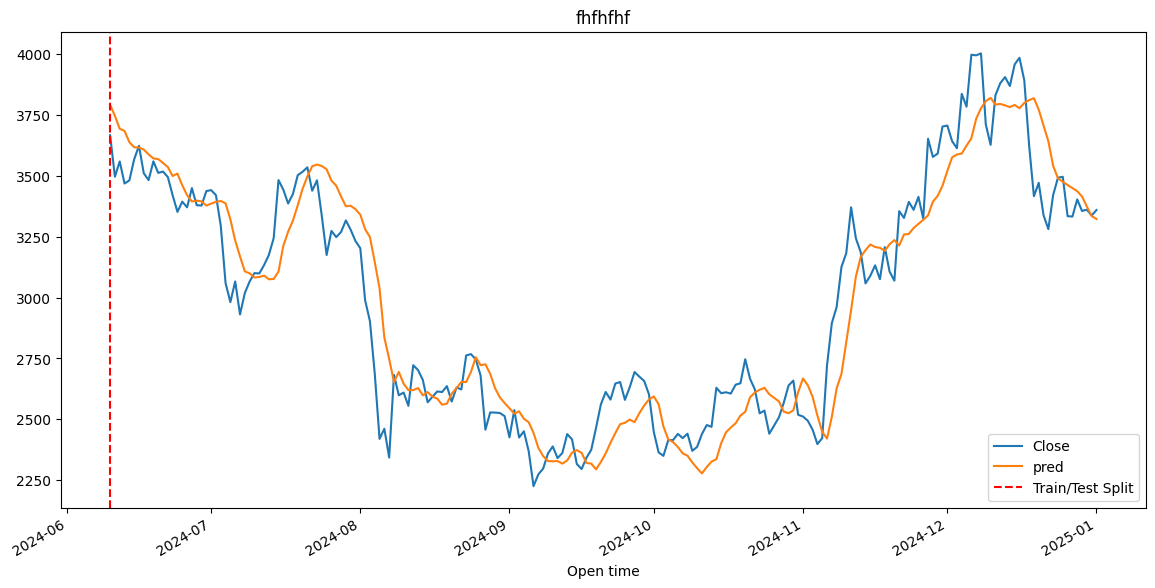

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

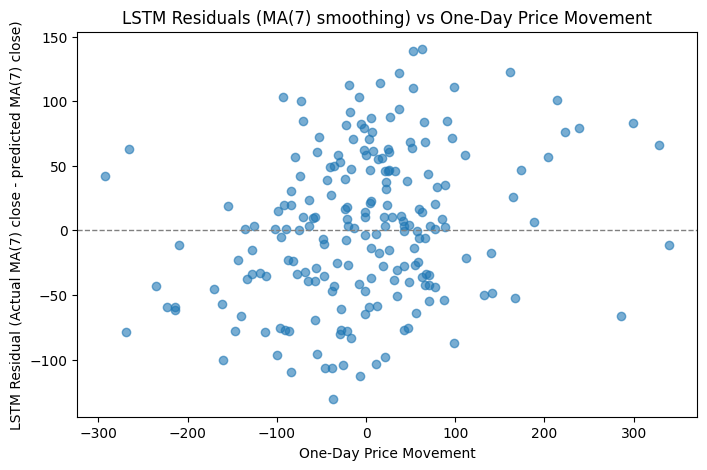

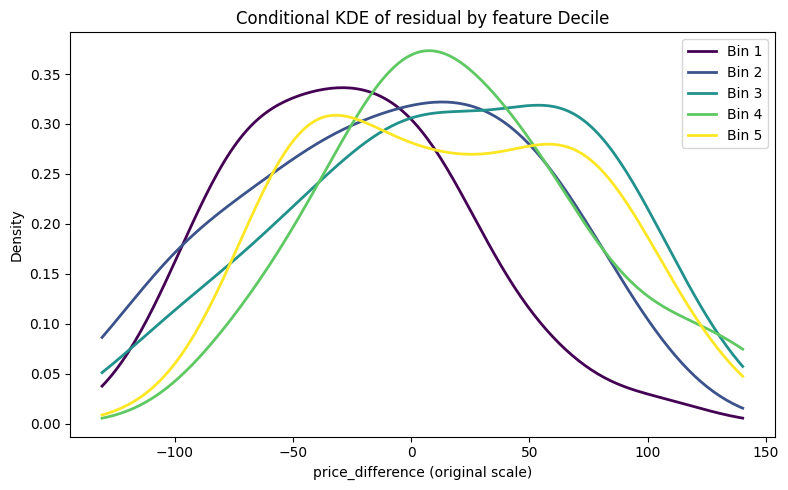

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)
X_feat = df['Close'].iloc[-len(y_pred_inv):] - df['Close'].iloc[-len(y_pred_inv)-1:-1].values

# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'One-Day Price Movement')
plt.ylabel('LSTM Residual (Actual MA(7) close - predicted MA(7) close)')
plt.title(f'[ETHUSDT] LSTM Residuals (MA(7) smoothing) vs One-Day Price Movement')
plt.show()



data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


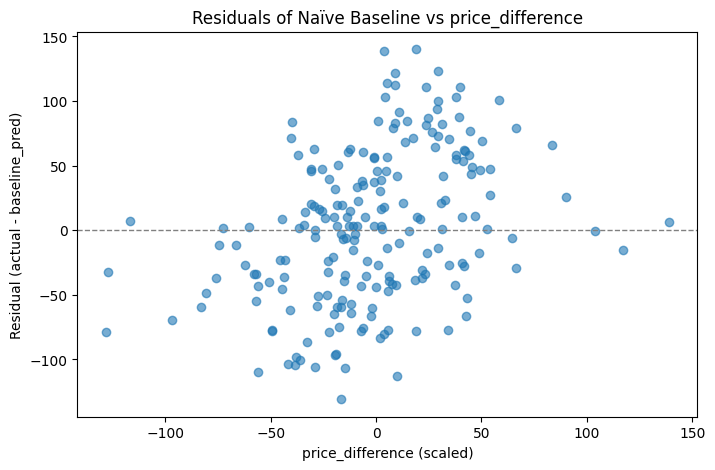

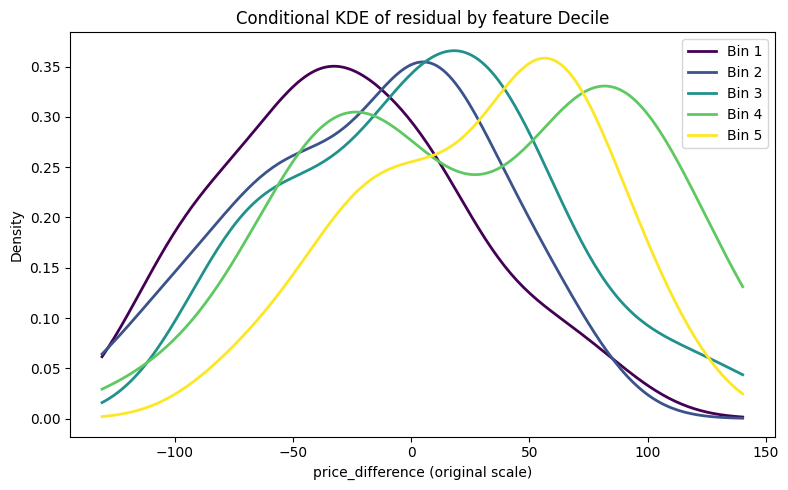

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()



data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)